<a href="https://colab.research.google.com/github/Benned-H/Summer2019/blob/master/Simple_Reinforcement_Learning_with_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 0: Q-Learning with Tables and Neural Networks [[Link]](https://medium.com/emergent-future/simple-reinforcement-learning-with-tensorflow-part-0-q-learning-with-tables-and-neural-networks-d195264329d0)

We begin with a simpler algorithm than we'll see in the next few tutorials. **Policy gradients** attempt to learn functions which map observations to actions, whereas **Q-Learning** attempts to learn the value of being in a given state, and taking an action there. Even DeepQ networks are just larger and more complex versions of the algorithm we'll discuss here.

We'll be working in the [FrozenLake](https://gym.openai.com/envs/FrozenLake-v0/) environment from OpenAI Gym. This environment is a 4x4 grid of blocks, with blocks being one of the start block, goal block, a safe block, or dangerous hole. We want our agent to navigate to the goal without falling down a hole, but the ice is slippery and we might not move exactly as the agent attempts to.

In [1]:
# Import Gym, create and view environment
import gym
env = gym.make('FrozenLake-v0')
env.render()


SFFF
FHFH
FFFH
HFFG


In [2]:
# View actions/observations
print(env.action_space)
print(env.observation_space)

Discrete(4)
Discrete(16)


Discrete spaces allow a fixed range of non-negative numbers. Thus we have 4 possible actions, 0 to 3, and 16 possible observations for which of the 16 squares our agent is on.

In [3]:
# Note: The environment isn't randomized.
# It's the same each time.
env.reset()
env.render()


SFFF
FHFH
FFFH
HFFG


Our reward at every step is 0, except when we enter the goal, where we receive a reward of 1. This means we need an algorithm that can learn with long-term expected rewards, which Q-Learning can. The simplest implementation of Q-Learning is a table of values for each state (row) and action (column) possible. We learn a value for how good it is to take a given action within a given state for each combination. First, initialize all $16\times4=64$ cells to 0.

To update our table, we'll use the Bellman equation. This states that "the expected long-term reward for a given action is equal to the immediate reward from the current action combined with the expected reward from the best future action taken at the following state." Put differently (in my words), we want to figure out how valuable some choice is in the future. We can break this question into two parts:
1. How valuable is this decision immediately? This is easy to answer, because we immediately see the next step following our decision.
2. How valuable is the best choice we can then make? We've now recursively broken the question down into a simpler problem.

This approach allows us to reuse the Q-table when estimating how to update the table for some current decision. Formally, we could write:

$Q(s,a)=r + \gamma(\text{max}\{Q(s',a')\})$, where the Q-value for some given state $s$ and action $a$ is the current reward $r$ plus the maximum discounted reward $\gamma$ according the the next state $s'$ our decision results in. The discount function $\gamma$ allows us to vary how important possible future rewards are compared to the present reward. Thus we slowly develop an accurate table of expected rewards for given actions in given states.

From [A Beginner's Guide to Deep Reinforcement Learning](https://skymind.ai/wiki/deep-reinforcement-learning#define):

We multiply future rewards by a **discount factor** in order to lessen the impact they have on present decisions. This makes future rewards worth less than present rewards, but the gamma $\gamma$ parameter lets us pick exactly how much. As an example, with $\gamma=0.8$, and a reward of 10 in 3 time steps, the present value of the reward is $0.8^3*10$. A gamma of 1 thus treats future rewards as just as valuable as immediate rewards.

In [0]:
import random

def discount(arr, gamma):
  """ Discounts a given list of rewards using the given gamma.
      Gives the same results as an example from a workshop, so I trust my code here. """
  
  for r in range(len(arr)): # Loop over all rewards
    for i in range(r + 1, len(arr)): # For all future rewards...
      arr[r] += gamma ** (i-r) * arr[i] # Add discounted future rewards
    
  return arr

In [5]:
discount([1,2,3,1,2,3,50], 0.56)

[5.140374425600002,
 7.393525760000001,
 9.631296000000003,
 11.841600000000003,
 19.360000000000003,
 31.000000000000004,
 50]

At this point, I'll attempt to code this out myself. These were helpful:
* Gym Discrete Space code [here](https://github.com/openai/gym/blob/master/gym/spaces/discrete.py)
* For [sampling a list](https://www.geeksforgeeks.org/python-random-sample-function/)

In [0]:
import numpy as np

class Q_Table_Agent:

    # Initializer
    def __init__(self, states, actions, gamma, learning_rate):
      self.Q_t = np.zeros((states, actions)) # Table dimension is: states by possible actions.
      self.g = gamma # The discount factor for this agent.
      self.lr = learning_rate # The learning rate for our Q-table updates.
      
    def max_col(self, row):
      """ Returns one of the columns with the max value in a given numpy row. """
      maximum = np.amax(row) # Find the maximum value in the row.
      winners = []
  
      for c in range(len(row)): # Loop over all values in the row.
        if (row[c] == maximum):
          winners.append(c) # Append columns containing the maximum value to list.
  
      return random.sample(winners, 1)[0] # Return a random one of these columns.
        
    def act(self, state):
      """ Chooses an action given some state. """
      row = self.Q_t[state] # Choose the maximum column for this state.
      return self.max_col(row) # This will be the action yielding the highest expected reward.
    
    def setTable(self, r, c, value):
      """ Sets Q_t[r][c] to the given value. """
      self.Q_t[r][c] = value
    
    def learn(self, s, a, new_s, reward):
      """ Learn based on action <a> we took in given state <s>. """
      
      max_exp = np.amax(self.Q_t[new_s]) # Find the maximum reward we can expect in the future.
      set_to = reward + self.g * max_exp # If our learning rate was 1, we'd set Q_t[s][a] to this.
      delta = self.lr * (set_to - self.Q_t[s][a]) # Change the reward by this much.
      
      self.Q_t[s][a] += delta
      
    def reset(self):
      """Resets the agent as if it was just created."""
      self.Q_t = np.zeros((len(self.Q_t), len(self.Q_t[0])))

In [0]:
# Create an agent for a few tests.

agent = Q_Table_Agent(env.observation_space.n, env.action_space.n, 0.95, 0.8)
agent.setTable(0,0,1)
agent.setTable(0,1,2)
agent.setTable(1,0,3)
agent.setTable(1,2,3)

In [8]:
# Pretend we're in this state, which action should we take? Seems to work.
agent.act(1)

0

In [0]:
# Q-Table Implementation on OpenAI Gym FrozenLake

episodes = 2000 # Number of episodes to train for.
timesteps = 500 # Cut the agent off after this many timesteps in any one episode.

agent = Q_Table_Agent(env.observation_space.n, env.action_space.n, 0.9, 0.8)

records = [] # To store our scores over all episodes.

for ep in range(episodes):
  state = env.reset() # Gets the state we start in, which is 0.
  
  for t in range(timesteps):
    action = agent.act(state)
    
    new_state, reward, done, info = env.step(action) # Try our action in the environment.
    
    if (done and reward == 0):
      agent.learn(state, action, new_state, -1) # Death case.
    else:
      agent.learn(state, action, new_state, reward) # Learn from what we did.
    
    state = new_state
    
    if done:
      records.append(reward) # Record if we won.
      break

0.2855

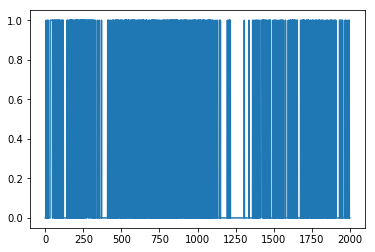

In [10]:
from matplotlib import pyplot as plt
plt.plot(records)

# We succeeded this % of the time.
sum(records)/episodes

In [11]:
print(agent.Q_t)

[[-0.59400663 -0.89133055 -0.89565769 -0.89434908]
 [-0.98377372 -0.99985577 -0.99992534 -1.10878463]
 [-1.33617503 -1.01649646 -0.23933175 -0.98423717]
 [-0.98944    -0.98716147 -0.97665723 -0.09681584]
 [-0.840275   -0.95408504 -0.96       -0.89841121]
 [ 0.          0.          0.          0.        ]
 [-0.99997764 -0.99999161 -0.99406814 -0.99998464]
 [ 0.          0.          0.          0.        ]
 [-0.99732671 -0.98218179 -0.9977372  -0.99601884]
 [-0.99937871 -1.12948531 -0.24391722 -0.99912146]
 [-0.11355975 -0.94933234 -0.96       -0.89720792]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [-0.96       -0.935424    0.57002357 -0.85703964]
 [-0.89510277 -0.61039844 -0.53253066  0.96259454]
 [ 0.          0.          0.          0.        ]]


As we can see, the agent is pretty terrible. The article tangentially mentions $\epsilon$-greedy agents, so I'd like to look into that.

## The Epsilon-Greedy Algorithm [[Link]](https://jamesmccaffrey.wordpress.com/2017/11/30/the-epsilon-greedy-algorithm/)

This simple algorithm is used in several areas of ML. A common use is the multi-armed bandit problem: Say we have $k=3$ slot machines. Each pays out with a different distribution, and we can only play 100 times. We want to simultaneously:
1. Experiment with each machine to get an idea of which pays out the most.
2. Get as much money as possible.

These options, often called "explore" and "exploit," represent the fundamental tradeoff we wish to solve. Epsilon-greedy does this extremely simply:

As we play, we track the average payout of each machine. We default to always selecting the machine with the highest current average payout. Let $\epsilon=$ some small value, say 0.1. We'll select this machine with probability $(1-\epsilon) + (\epsilon-k)$, and all other machines with probability $(\epsilon-k)$.

More conceretely, on each attempt:
1. Generate a random number  $p$ between 0 and 1.
2. If $p>\epsilon$, select the highest-paying machine. If not, select a random machine.

Over time, we'll tend towards the highest-paying machine while still randomly gathering data on the other machines. As a final summary, we greedily pick the best current option most of the time, but pick a random option with small $\epsilon$ probability. That's it.

*--Fin 5/28/2019--*

Now to add that into our code:

In [0]:
class Q_Table_Agent_ep(Q_Table_Agent):

    # Initializer, overrides parent's init.
    def __init__(self, states, actions, gamma, learning_rate, epsilon):
      self.Q_t = np.zeros((states, actions)) # Table dimension is: states by possible actions.
      self.g = gamma # The discount factor for this agent.
      self.lr = learning_rate # The learning rate for our Q-table updates.
      self.ep = epsilon # For epsilon-greedy searching of options.
      
    def act(self, state):
      """ Chooses an action given some state. """
      p = random.random() # Generate random number 0 to 1.
      
      if p < self.ep: # Explore.
        return random.randint(0, self.Q_t.shape[1]-1)
      
      # Else case, exploit.
      row = self.Q_t[state] # Choose the maximum column for this state.
      return self.max_col(row) # This will be the action yielding the highest expected reward.

In [0]:
# Epsilon-greedy Q-Table Implementation on OpenAI Gym FrozenLake

episodes = 2000 # Number of episodes to train for.
timesteps = 500 # Cut the agent off after this many timesteps in any one episode.

ep_agent = Q_Table_Agent_ep(env.observation_space.n, env.action_space.n, 0.9, 0.8, 0.01)

ep_records = [] # To store our scores over all episodes.

for ep in range(episodes):
  state = env.reset() # Gets the state we start in, which is 0.
  
  for t in range(timesteps):
    action = ep_agent.act(state)
    
    new_state, reward, done, info = env.step(action) # Try our action in the environment.
    
    if (done and reward == 0):
      ep_agent.learn(state, action, new_state, -1) # Death case.
    else:
      ep_agent.learn(state, action, new_state, reward) # Learn from what we did.
    
    state = new_state
    
    if done:
      ep_records.append(reward) # Record if we won.
      break

0.3605

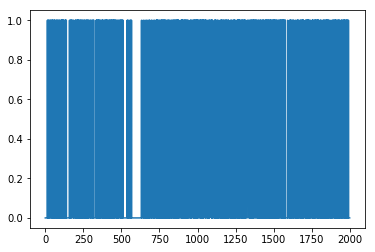

In [14]:
plt.plot(ep_records)

# We succeeded this % of the time.
sum(ep_records)/episodes

In [15]:
print(ep_agent.Q_t)

[[-0.19715727 -0.54285415 -0.04843547 -0.16943268]
 [-0.9720719  -0.92833557 -0.96900057 -0.1184625 ]
 [-0.38136943 -0.17165466 -0.85307302 -0.80299819]
 [-0.84018832 -0.37766928 -0.86347835 -0.04626952]
 [-0.099901   -0.99314439 -0.85790868 -0.2868971 ]
 [ 0.          0.          0.          0.        ]
 [-0.68862593 -0.99999858 -0.99986174 -0.999237  ]
 [ 0.          0.          0.          0.        ]
 [-0.79605784 -0.94818437 -0.75003461 -0.24679802]
 [-0.94072281 -0.39642032 -0.93275263 -0.89456228]
 [-1.3377369  -0.99796627 -0.99161519 -0.97897071]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [-0.79922216 -0.94278081 -0.00265286 -0.98999812]
 [-0.50154901  0.93482316 -0.42247918 -0.510846  ]
 [ 0.          0.          0.          0.        ]]


In [0]:
# Close the previous FrozenLake environment.
env.close()

In [0]:
import copy

class EnvRunner:
    # Initializer
    def __init__(self, env_name):
      self.env = gym.make(env_name) # Create environment of given type.
      
    def runEnv(self, ag, episodes, timesteps):
      """Trains the given agent with given conditions.
         Returns the average reward over these episodes."""
      
      agent = copy.deepcopy(ag)
      
      scores = [] # To store our scores over all episodes.
      
      for ep in range(episodes):
        state = self.env.reset()
  
        for t in range(timesteps):
          action = agent.act(state)
    
          # Try our action in the environment.
          new_state, reward, done, info = self.env.step(action)
          
          # Learn from what we did.
          agent.learn(state, action, new_state, reward)
    
          state = new_state
    
          if done:
            scores.append(reward) # Record if we won.
            break
            
      return sum(scores) / episodes
    
    def getEnvParams(self):
      return self.env.observation_space.n, self.env.action_space.n

In [0]:
class GridSearch:
  # Tests an agent of a given type with varying hyperparameters.
  
  def __init__(self, runner, eps):
    self.runner = runner
    self.episodes = eps
    
  def search(self, agent, attrs, vals, keep_num):
    """Searches over all combinations of the given attribute values."""
    if len(attrs) != len(vals):
      print("ERROR:", len(attrs), "attributes and", len(vals), "values given.")
      return
    
    for attr in attrs:
      if hasattr(agent, attr) == False:
        print("ERROR: Agent does not have attribute", attr)
        return
      
    combinations = 1
    for val_list in vals:
      combinations *= len(val_list)
      
    winners = [float("-inf")] * keep_num
    
    curr_indices = [0] * len(attrs)
    curr_indices[len(attrs)-1] = -1 # Account for initial while loop increment.
    curr_attr = len(attrs) - 1 # The attribute we're currently iterating over. Start at the 'rightmost' attribute.
    
    counter = 0
    while True: # Loop until all combinations exhausted.
      curr_attr = len(attrs) - 1
      curr_indices[curr_attr] += 1 # Increment the current attribute by 1.
        
      while(curr_indices[curr_attr] > len(vals[curr_attr]) - 1): # Overflow case.
        curr_indices[curr_attr] = 0
        curr_attr -= 1
        curr_indices[curr_attr] += 1 # Increment the current attribute by 1.
        if curr_attr == -1:
          return winners
          
      # When we reach here, we hopefully have a new combination of parameters.
      # Set the agent to have each of these parameters.
      counter += 1
      print("Testing combination", counter, "of", combinations)
      
      output = ""
      
      for i, attr in enumerate(attrs):
        attr_index = curr_indices[i]
        val = vals[i][attr_index]
        setattr(agent, attr, val)
        output = output + str(val) + " "
        
      print(output)
      
      average = self.runner.runEnv(agent, self.episodes, 100)
      print(average)
      
      # Track the best combinations
      if average > winners[0]:
        winners[0] = average
        winners.sort()

In [0]:
env = gym.make('FrozenLake-v0')

In [0]:
runner = EnvRunner('FrozenLake-v0')
searcher = GridSearch(runner, 2000)

agent = Q_Table_Agent_ep(env.observation_space.n, env.action_space.n, 0.9, 0.8, 0.01)

In [21]:
results = searcher.search(agent, ["g", "lr", "ep"], [[0.6,0.8,1],[0.75,0.85,0.95],[0.01,0.05,0.1]], 10)

Testing combination 1 of 27
0.6 0.75 0.01 
0.082
Testing combination 2 of 27
0.6 0.75 0.05 
0.0875
Testing combination 3 of 27
0.6 0.75 0.1 
0.0675
Testing combination 4 of 27
0.6 0.85 0.01 
0.0935
Testing combination 5 of 27
0.6 0.85 0.05 
0.0835
Testing combination 6 of 27
0.6 0.85 0.1 
0.0915
Testing combination 7 of 27
0.6 0.95 0.01 
0.23
Testing combination 8 of 27
0.6 0.95 0.05 
0.0965
Testing combination 9 of 27
0.6 0.95 0.1 
0.0685
Testing combination 10 of 27
0.8 0.75 0.01 
0.1715
Testing combination 11 of 27
0.8 0.75 0.05 
0.1375
Testing combination 12 of 27
0.8 0.75 0.1 
0.1085
Testing combination 13 of 27
0.8 0.85 0.01 
0.114
Testing combination 14 of 27
0.8 0.85 0.05 
0.184
Testing combination 15 of 27
0.8 0.85 0.1 
0.1165
Testing combination 16 of 27
0.8 0.95 0.01 
0.3385
Testing combination 17 of 27
0.8 0.95 0.05 
0.139
Testing combination 18 of 27
0.8 0.95 0.1 
0.0885
Testing combination 19 of 27
1 0.75 0.01 
0.019
Testing combination 20 of 27
1 0.75 0.05 
0.0775
Testin

In [22]:
results

[0.1085, 0.114, 0.1165, 0.1375, 0.139, 0.1715, 0.184, 0.23, 0.3385, 0.3625]

# TO DO
* Experiment with gamma, learning rate, and epsilon values (grid search could be automated, read articles?)
